In [1]:
# Strategy: Triple Filter Strategy
# --------------------------------
# 1. Trend Filter (EMA Crossover):
#    - Compute two exponential moving averages:
#      - Short EMA (e.g., 20-day)
#      - Long EMA (e.g., 50-day)
#    - If Short EMA > Long EMA, we consider the market in an uptrend.
#    - If Short EMA < Long EMA, it's a downtrend.

# 2. Momentum Filter (RSI):
#    - Compute the Relative Strength Index (RSI), which measures momentum.
#    - If RSI > 50, momentum is positive → supports a buy.
#    - If RSI < 50, momentum is negative → supports a sell.

# 3. Volatility Filter (ATR):
#    - Compute the Average True Range (ATR), a measure of volatility.
#    - If current ATR > its moving average, the market has enough activity to trade.
#    - This helps avoid trading during flat or low-volatility periods.

# Trading Logic:
# --------------
# Buy Signal:
#   - EMA20 > EMA50 (uptrend)
#   - RSI > 50 (positive momentum)
#   - ATR > average ATR (market is active)
#
# Sell Signal:
#   - EMA20 < EMA50 (downtrend)
#   - RSI < 50 (negative momentum)
#   - ATR > average ATR (market is active)

# Note:
# - Positions are shifted by 1 day to avoid lookahead bias.
# - Strategy return is calculated only when all 3 filters align.
# - This system avoids false signals in choppy or weak trends.

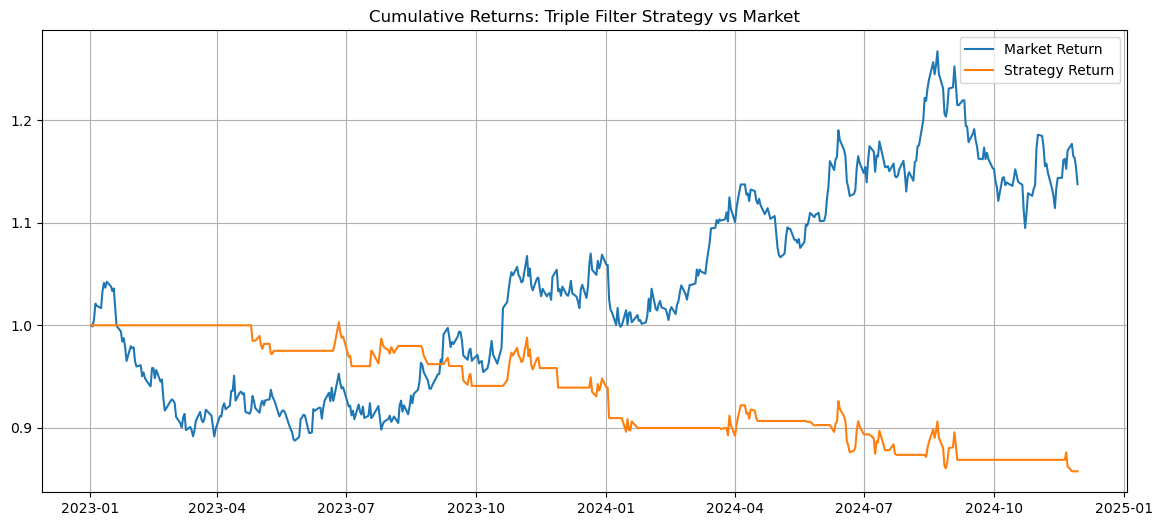

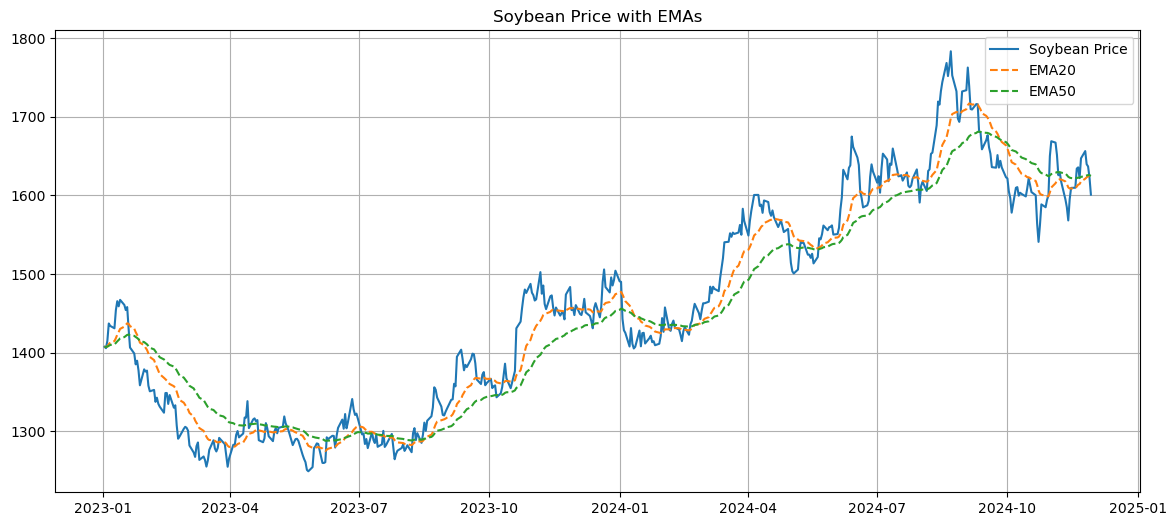

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------
# STEP 1: Simulate soybean price data
# ---------------------------------------------
np.random.seed(42)
n_days = 500
mu = 0.0002
sigma = 0.01
start_price = 1400

log_returns = np.random.normal(loc=mu, scale=sigma, size=n_days)
prices = start_price * np.exp(np.cumsum(log_returns))
dates = pd.date_range(start='2023-01-01', periods=n_days, freq='B')
df = pd.DataFrame({'Close': prices}, index=dates)

# ---------------------------------------------
# STEP 2: Indicators (EMA, RSI, ATR)
# ---------------------------------------------

# EMA
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()

# RSI (14-period)
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# ATR (14-period)
df['High'] = df['Close'] * (1 + np.random.uniform(0, 0.01, n_days))  # add random noise for high
df['Low'] = df['Close'] * (1 - np.random.uniform(0, 0.01, n_days))   # add random noise for low
df['Prev_Close'] = df['Close'].shift(1)

tr1 = df['High'] - df['Low']
tr2 = (df['High'] - df['Prev_Close']).abs()
tr3 = (df['Low'] - df['Prev_Close']).abs()
df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()
df['ATR_avg'] = df['ATR'].rolling(window=50).mean()

# ---------------------------------------------
# STEP 3: Define Trading Signals
# ---------------------------------------------
# Conditions
trend_up = df['EMA20'] > df['EMA50']
momentum_up = df['RSI'] > 50
volatility_enough = df['ATR'] > df['ATR_avg']

# Buy: All conditions must be True
df['Signal'] = 0
df.loc[trend_up & momentum_up & volatility_enough, 'Signal'] = 1

# Sell: Opposite trend and momentum, with enough volatility
trend_down = df['EMA20'] < df['EMA50']
momentum_down = df['RSI'] < 50
df.loc[trend_down & momentum_down & volatility_enough, 'Signal'] = -1

# Shift signals to avoid lookahead bias
df['Position'] = df['Signal'].shift(1)

# ---------------------------------------------
# STEP 4: Compute Returns
# ---------------------------------------------
df['Market Return'] = df['Close'].pct_change()
df['Strategy Return'] = df['Position'] * df['Market Return']
df[['Market Return', 'Strategy Return']] = df[['Market Return', 'Strategy Return']].fillna(0)

df['Cumulative Market'] = (1 + df['Market Return']).cumprod()
df['Cumulative Strategy'] = (1 + df['Strategy Return']).cumprod()

# ---------------------------------------------
# STEP 5: Plotting
# ---------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(df['Cumulative Market'], label='Market Return')
plt.plot(df['Cumulative Strategy'], label='Strategy Return')
plt.title("Cumulative Returns: Triple Filter Strategy vs Market")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Soybean Price')
plt.plot(df['EMA20'], label='EMA20', linestyle='--')
plt.plot(df['EMA50'], label='EMA50', linestyle='--')
plt.title("Soybean Price with EMAs")
plt.legend()
plt.grid(True)
plt.show()